In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from collections.abc import Iterable
import functools

from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import numpy as np       
import copy

In [ ]:
def MonteCarloSampling(target_dist, f, num_qubits, num_ancillas, epsilon=0.05, degree=1, scale=1, order=None):
    A_qr = QuantumRegister(num_qubits+1)
    A = QuantumCircuit(A_qr)
    
    state_prep(A, A_qr, target_dist, num_qubits)
    f_on_objective(A, A_qr, f, epsilon=epsilon, degree=degree, scale=scale, order=order)
    
    qc = AE_Subroutine(num_qubits, num_ancillas, A)
    
    return qc    

In [ ]:
def state_prep(qc, qr, target_dist, num_qubits):
    """
    Use controlled Ry gates to construct the superposition Sum \sqrt{p_i} |i>
    """
    r_probs = region_probs(target_dist, num_qubits)
    regions = r_probs.keys()
    
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr)
    
    for r in regions:
        norm = 1
        num_controls = len(r) - 1
        
        super_key = r[:num_controls]
        try:
            norm = r_probs[super_key]
        except KeyError:
            if len(super_key) == 0:
                pass
            else:
                flipped_last = 1-int(super_key[-1])
                norm = 1 - r_probs[super_key[:num_controls-1] + str(flipped_last)]
        
        p = r_probs[r] / norm
        theta = -2*np.arcsin(np.sqrt(p))
        
        if r == '1':
            qc.ry(theta, num_qubits-1)
            
        else:
            
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.x(num_qubits-1 - k)
            
            controls = [qr[num_qubits-1 - i] for i in range(num_controls)]
            qc.mcry(theta, controls, qr[num_qubits-1 - num_controls], q_ancillae=None)
            
            for k in range(num_controls):    
                if r[k] == '0':
                    qc.x(num_qubits-1 - k)

In [205]:
qr_ = QuantumRegister(4)
cr_ = ClassicalRegister(1)
qc_ = QuantumCircuit(qr_, cr_)

#qc_.x(0)
#qc_.x(1)
#qc_.x(2)

f_on_objective(qc_, qr_, power_f)

qc_.measure([3], [0])

0.5848035476425733


In [206]:
from qiskit import execute, Aer
backend = Aer.get_backend("qasm_simulator")
job = execute(qc_, backend, shots=1000)
result = job.result()
counts = result.get_counts()

print(counts)

{'0': 784, '1': 216}


In [204]:
def f_on_objective(qc, qr, f, epsilon=0.1, degree=2, scale=1, order=None):
    """
    Assume last qubit is the objective. Function f is evaluated on first n-1 qubits
    """
    num_qubits = qc.num_qubits - 1
    c_star = (2*epsilon)**(1/(degree+1))
    
    f_ = functools.partial(f, num_qubits=num_qubits, power=2)
    zeta_ = functools.partial(zeta_from_f, f=f_, epsilon=epsilon, degree=degree, c=c_star)
    
    x = np.linspace(0.0, 2**(num_qubits) - 1, num= degree+1)
    poly_fitted = Polynomial.fit(x, zeta_(x), degree) #scale, order) 
    poly = c_star*poly_fitted + (np.pi/4)
    
    
    
    b_exp = binary_expansion(num_qubits, poly)
    
    for controls in b_exp.keys():
        theta = b_exp[controls]
        if len(controls)==0:
            qc.ry(theta, qr[num_qubits])
        else:
            qc.mcry(theta, [qr[num_qubits - 1 - i] for i in list(controls)], qr[num_qubits], q_ancillae=None)

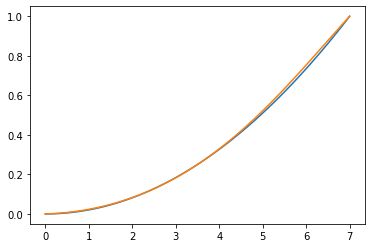

In [134]:
num_qubits=3
epsilon=0.1
degree=2

f_ = functools.partial(power_f, num_qubits=num_qubits, power=2)
plt.plot(x_plot, f_(x_plot), label="f")

c_star = (2*epsilon)**(1/(degree+1))
x_plot = np.linspace(0.0, 2**(num_qubits) - 1, num=100)
poly = f_on_objective([],[],power_f)
def better_fit(x):
    return (((np.sin(c_star*poly(x) + (np.pi/4))**2) - 0.5) / c_star) + 0.5
plt.plot(x_plot, better_fit(x_plot), label=f"degree={degree}")

In [5]:
def power_f(i, num_qubits, power):
    if isinstance(i, Iterable):
        out = []
        for val in i:
            out.append((val / ((2**num_qubits) - 1))**power)
        return np.array(out)
    else:
        return (i / ((2**num_qubits) - 1))**power

In [60]:
def zeta_from_f(i, f, epsilon, degree, c):
    """
    Intermediate polynomial derived from f to serve as angle for controlled Ry gates.
    """
    rad = np.sqrt(c*(f(i) - 0.5) + 0.5)
    return (np.arcsin(rad) - (np.pi/4)) / c

def simplex(n, k):
    """
    Get all ordered combinations of n integers (zero inclusive) which add up to k; the n-dimensional k simplex.
    """
    if k == 0:
        z = [0]*n
        return [z]
    l = [] 
    
    for p in simplex(n,k-1):
        
        for i in range(n):
            a = p[i]+1
            ns = copy.copy(p)
            ns[i] = a
            if ns not in l:
                l.append(ns)
    return l

def binary_expansion(num_qubits, poly):
    """
    Convert a polynomial into expression replacing x with its binary decomposition x_0 + 2 x_1 + 4 x_2 + ... 
    
    Simplify using (x_i)^p = x_i for all integer p > 0 and collect coefficients of equivalent expression
    
    """
    n = num_qubits
    if isinstance(poly, Polynomial):
        poly_c = poly.coef[::-1]
    else:
        poly_c = poly
        
    out_front = {}
    out_front[()] = poly_c[0]
    for k in range(1,len(poly_c)):
        for pow_list in simplex(n,k):
            two_exp, denom, t = 0, 1, 0
            for power in pow_list:
                two_exp += t*power
                denom *= np.math.factorial(power)
                t+=1
            nz = np.nonzero(pow_list)[0]
            key = tuple(nz)
            if key not in out_front.keys():
                out_front[key] = 0
            out_front[key] += poly_c[k]*((np.math.factorial(k) / denom) * (2**(two_exp)))
    return out_front

In [4]:
def starting_regions(num_qubits):
    """
    For use in bisection search for state preparation subroutine. Fill out the necessary region labels for num_qubits.    
    """
    sub_regions = []
    sub_regions.append(['1'])
    for d in range(1,num_qubits):
        region = []
        for i in range(2**d):
            key = bin(i)[2:].zfill(d) + '1'
            region.append(key)
        sub_regions.append(region)
        
    return sub_regions

def region_probs(target_dist, num_qubits):
    """
    Fetch bisected region probabilities for the desired probability distribution {[p1], [p01, p11], [p001, p011, p101, p111], ...}.
    """
    
    regions = starting_regions(num_qubits)
    probs = {}
    n = len(regions)
    for k in range(n):
        for string in regions[k]:
            p = 0
            b = n-k-1
            for i in range(2**b):
                subkey = bin(i)[2:].zfill(b)
                if b == 0:
                    subkey = ''
                p += target_dist[string+subkey]
            probs[string] = p
    return probs

In [ ]:
def AE_Subroutine(num_qubits, num_ancillas, A_circ):
    
    qr_state = QuantumRegister(num_qubits+1)
    qr_ancilla = QuantumRegister(num_ancillas)
    cr = ClassicalRegister(num_ancillas)

    cQ_ = Ctrl_Q(num_qubits, A_circ)
    
    qc = QuantumCircuit(qr_state, qr_ancilla, cr)
    
    # Prepare state from A, and 
    qc.append(A_circ, qr_state)
    for i in range(num_ancillas):
        qc.h(qr_ancilla[i])
    
    repeat = 1
    for j in range(num_ancillas):
        for k in range(repeat):
            qc.append(cQ_, [qr_ancilla[j]] + [qr_state[l] for l in range(num_qubits+1)])
        repeat *= 2
    
    qc.barrier()
    
    qc.append(QFT(num_qubits=num_ancillas, inverse=True), qr_ancilla[::-1])
    
    qc.barrier()
    
    qc.measure([qr_ancilla[m] for m in range(num_ancillas)], list(range(num_ancillas)))
    
    return qc

In [ ]:
# Get the controlled grover-like operator
def Ctrl_Q(num_qubits, A_circ):
    # index 0 is the objective qubit, and indexes 1 through n are state qubits
    qc = QuantumCircuit(num_qubits+1)
    
    temp_A = copy.copy(A_circ)
    A_gate = temp_A.to_gate()
    A_gate_inv = temp_A.inverse().to_gate()
    
    ### Each cycle in Q applies S_chi, A_circ_inverse, S_0, A_circ
    # S_chi
    qc.z(0)
        
    # A_circ_inverse
    qc.append(A_gate_inv, [i for i in range(num_qubits+1)])
        
    # S_0
    for i in range(num_qubits):
        qc.x(i+1)
    qc.x(0)
    qc.h(0)
    
    qc.mcx([x+1 for x in range(num_qubits)], 0)
    
    qc.h(0)
    qc.x(0)
    for i in range(num_qubits):
        qc.x(i+1)
        
    # A_circ
    qc.append(A_gate, [i for i in range(num_qubits+1)])
    
    
    qc.to_gate(label='Q')
    Ctrl_Q_ = qc.control(1)
    return Ctrl_Q_

def bitstring_to_a(counts):
    est_counts = {}
    for key in counts.keys():
        r = counts[key]
        m = len(key)
        num = int(key,2) / (2**m)
        a_est = round((np.sin(np.pi * num) )** 2, 7)
        if a_est not in est_counts.keys():
            est_counts[a_est] = 0
        est_counts[a_est] += r
    return est_counts

def a_from_s_int(s_int, num_qubits):
    theta = s_int * np.pi / (2**num_qubits)
    a = round(np.sin(theta)**2, 7)
    return a